# Lab 2 - Clustering
In this lab we will look at clustering with k-means and GMMs. We will work on putting together the skeleton code to create the functionality of the algorithms, and then we will cluster the Fisher Iris dataset. We will finish by looking at the sklearn implementations of these algorithms.

<b>Important note:</b> 
    Please do not edit the existing code snippets. Instead, add your functionality into the TODO sections. Read the entire skeleton structure first and think about how you should structure the code you are adding in carefully.
    
There are <b>42</b> TODOs in this lab. It may seem like a lot but don't worry. Many are just selecting hyper-parameters and many of the visualisation TODOs are the same.

## Task 2.1 - Data Exploration
This task will load the data and explore the feature space of the observations. We will plot two feature dimensions against eachother, labeling them based on colour from the known class IDs.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

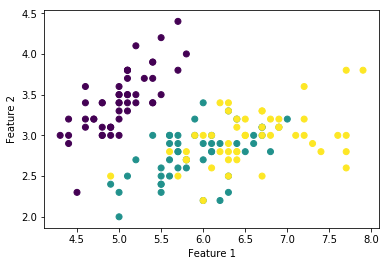

In [22]:
data = np.load('Iris_data.npy')
labels = np.load('Iris_labels.npy')

plt.scatter(data[:,0], data[:,1], c=labels)
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2')
plt.show() 



## Task 2.2 - K-means Clustering 
The task here is to fill out the skeleton code in order to complete the k-means implementation. Follow the lecture notes and take some hints along the way. We first define a function to calculate the Euclidean distance between each of the cluster centres and the data, then we initialise our hyper-parameters and create a loop to fit our clusters to the data.

### K-Means algorithm:

Setup: Select random initial set of k cluster centers

Loop:

    for i = 1 to maximum number of iterations
        calculate distance from training points to cluster centroids
        update class labels
        recalculate centroid locations

In [23]:
# Definition of euclidean distance function between cluster centroid and matrix of datapoints
def euclidean_distance(k_centroid, datapoints):
    dists = np.zeros(shape=[datapoints.shape[0], k_centroid.shape[0]])

    for i_k in range(k_centroid.shape[0]):
        centre = np.tile(k_centroid[i_k, :], (datapoints.shape[0], 1))
        diff = centre - datapoints
        sum_of_squared_difference = np.zeros([datapoints.shape[0]])
        for i_dimension in range(k_centroid.shape[1]):
            sum_of_squared_difference += (diff[:, i_dimension]**2)
        dists[:, i_k] = np.sqrt(sum_of_squared_difference)

    return dists


def k_means(data, k, n_iteration):
    # TODO: Select cluster centroids. Hint: np.random.choice into data with k
    k_centroid = data[np.random.choice(data.shape[0], k), :] 
   
    for i_iteration in range(n_iteration): 
        prev_k_centroid = k_centroid

        # Calculate distances
        dists = euclidean_distance(k_centroid, data)

        # Reassign labels
        # TODO: Get cluster label based on distance from centroid. Hint: np.argmin.
        predicted_label = np.argmin(dists, axis=1) 

        # Recalculate centroids
        new_centroid = np.zeros(shape=[k, data.shape[1]])
        for i_k in range(k): 
            # Get all datapoints alocated to cluster i_k
            cluster_data = data[predicted_label == i_k, :]
            # TODO: Slice into data with predicted_label.
            # Calculate the mean of this cluster
            new_centroid[i_k, :] = np.mean(cluster_data, axis=0) 
            # TODO: Calculate mean of datapoints.

        # Assign the new cluster centers
        k_centroid = new_centroid

        print('Iteration {0}: total update distance of centroids: {1}'.format(
            i_iteration, np.sum(np.abs(new_centroid - prev_k_centroid))), end='\r')
        
    return predicted_label, k_centroid

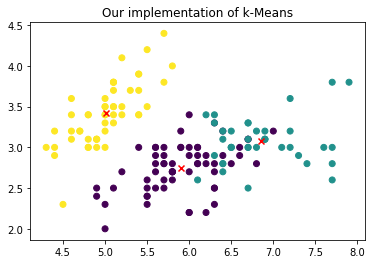

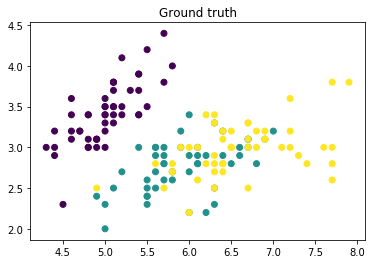

In [24]:
k = 3 
n_iteration = 10

predicted_label, k_centroid = k_means(data, k, n_iteration)

# Visualisation of model predictions
# TODO: Plot two feature dimensions against eachother, label with the predicted cluster labels.
# TODO: Plot the cluster centroids on top. Hint: use a different shaped marker with 'marker="x"'.
# TODO: Label axes correctly.
plt.scatter(data[:,0], data[:,1], c=predicted_label)
plt.scatter(k_centroid[:,0], k_centroid[:,1], marker='x', c='r')
plt.title('Our implementation of k-Means')
plt.show()

# Visualisation of ground truth
# TODO: Plot two feature dimensions against eachother, label with the ground truth labels.
# TODO: Label axes correctly.
plt.scatter(data[:,0], data[:,1], c=labels)
plt.title('Ground truth')
plt.show()

## Task 2.3 - Gaussian Mixture Models
The task here is to fill out the skeleton code in order to complete the GMM implementation. Follow the lecture notes and take some hints along the way. We first define some functions for the algorithm, followed by initialisation of the parameters, and finally we implement the loop within which we fit our Gaussians to our data.

### GMM Algorithm:
Setup: Initialise Gaussian distribution centroid, standard deviations and mixing coefficients using k-means coefficients.

Loop: 

    Compute E-Step: calculate posteriors for the data given current Gaussian parameters 
    Compute M-Step: update model parameters 

In [35]:
# TODO: Figure out which one is the E-Step and which is the M-Step.

def multivariate_gaussian_density(x, mu, cov):
    size = x.shape[0]
    det = np.linalg.det(cov)
    norm_const = 1.0 / ((2*np.pi)**(size/2) * det ** (1.0/2))
    x_mu = x - mu
    inv = np.linalg.inv(cov)
    result = np.e**(-(1.0/2) * (x_mu @ inv @ x_mu.T))

    return norm_const * result


def likelihood(x, centroids, cov, mix):
    p = np.zeros([x.shape[0], centroids.shape[0]])
    p_total = np.zeros(x.shape[0])
    posteriors = np.zeros([x.shape[0], centroids.shape[0]])

    for i_sample in range(x.shape[0]):
        for i_cluster in range(centroids.shape[0]):
            p[i_sample, i_cluster] = multivariate_gaussian_density(
                x[i_sample, :].T, centroids[i_cluster, :], cov[:, :, i_cluster])
            p_total[i_sample] = p_total[i_sample] + p[i_sample, i_cluster]

        for i_cluster in range(centroids.shape[0]):
            posteriors[i_sample, i_cluster] = (
                p[i_sample, i_cluster] * mix[i_cluster]) / (p_total[i_sample] * mix[i_cluster])

    return posteriors


def update_params(data, posteriors, mix, cov, centroids):
    
    # Transpose due to numpy's handling of dimensions
    data = data.T
    
    # Update mixing coefs
    # TODO: Use equation on lab sheet to calculate new mixing coefficient.
    cluster_weight = np.sum(posteriors, axis=0)
    new_mix = cluster_weight/len(posteriors)
    
    print(posteriors.shape, cluster_weight.shape, new_mix.shape)

    # Update centroids
    new_centroids = np.zeros(centroids.shape)
    for i_cluster in range(centroids.shape[0]):
        new_centroids[i_cluster, :] = np.sum(posteriors[:, i_cluster] * data, axis=1) / cluster_weight[i_cluster]

    # Update covariance matrices
    new_cov = np.zeros(cov.shape)
    for i_cluster in range(centroids.shape[0]):
        mu_centred_data = data - np.expand_dims(new_centroids[i_cluster, :], axis=-1)
        for i_sample in range(data.shape[1]):
            cov = mu_centred_data[:, i_sample:i_sample+1] @ mu_centred_data[:, i_sample:i_sample+1].T
            scaled_cov = posteriors[i_sample, i_cluster] * cov
            new_cov[:, :, i_cluster] += scaled_cov
            
        new_cov[:, :, i_cluster] /= cluster_weight[i_cluster]

    return new_mix, new_cov, new_centroids

### Initialise parameters
Initialise the number of components, the number of iterations and the Gaussian parameters (mus, sigmas, mixings).

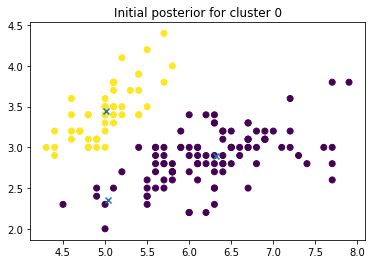

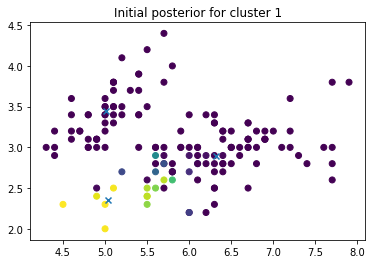

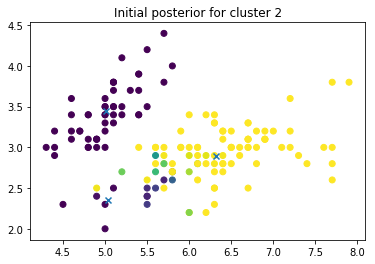

In [36]:
g = 3 # TODO: Select a number of Gaussians.
n_iteration = 10 # TODO: Select a number of iterations.

cluster_centroids = np.zeros([g, data.shape[1]])
cov = np.zeros([data.shape[1], data.shape[1], g])
mix = np.zeros(g)

# TODO: Understand what is happening here. Hint: clustering part 2 lecture, slide 10.
predicted_label, k_centroid = k_means(data, g, 2)
for i_cluster in range(g):
    data_in_cluster = data[predicted_label == i_cluster, :]
    cluster_centroids[i_cluster, :] = np.mean(data_in_cluster, axis=0)
    cov[:, :, i_cluster] = np.cov(data_in_cluster.T)
    mix[i_cluster] = data_in_cluster.shape[0] / data.shape[0]
    
# Visualisation of initial posteriors
for i_cluster in range(g):
    plt.scatter(data[:, 0], data[:, 1], c=likelihood(data, cluster_centroids, cov, mix)[:,i_cluster])
    plt.scatter(k_centroid[:, 0], k_centroid[:, 1], marker='x')
    plt.title('Initial posterior for cluster {0}'.format(i_cluster))
    plt.show()

### Main loop of GMM fitting
Loop over our iterations, computing steps E and M repeatedly.

(150, 3) (3,) (3,)
Iteration 0
(150, 3) (3,) (3,)
Iteration 1
(150, 3) (3,) (3,)
Iteration 2
(150, 3) (3,) (3,)
Iteration 3
(150, 3) (3,) (3,)
Iteration 4
(150, 3) (3,) (3,)
Iteration 5
(150, 3) (3,) (3,)
Iteration 6
(150, 3) (3,) (3,)
Iteration 7
(150, 3) (3,) (3,)
Iteration 8
(150, 3) (3,) (3,)
Iteration 9


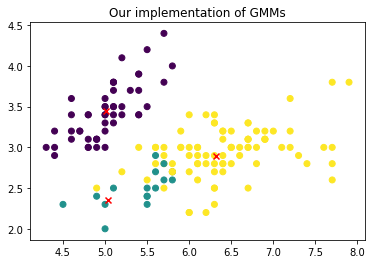

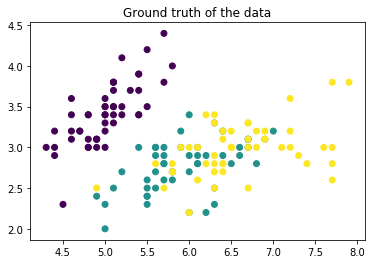

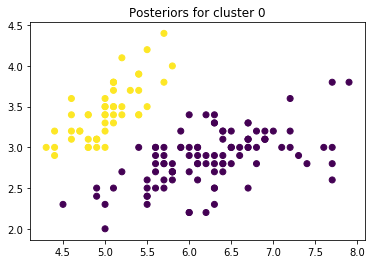

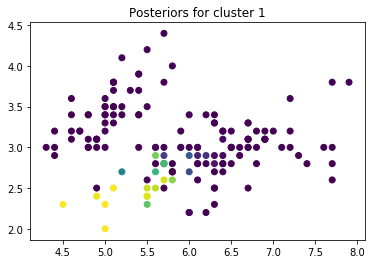

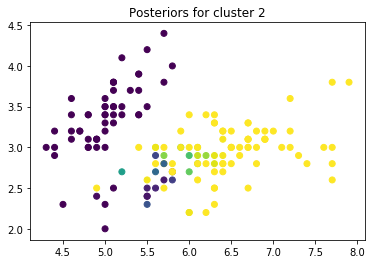

In [55]:
for i in range(n_iteration):
    #E-Step
    # TODO: Call E-Step function.
    posteriors = likelihood(data, cluster_centroids, cov, mix)

    #M-Step
    # TODO: Call M-Step function.
    mix, cov, centroids = update_params(data, posteriors, mix, cov, cluster_centroids)
    
    print('Iteration {0}'.format(i))
    
    

#Predict labels
# TODO: Get cluster label based on posterior. Hint: argmax.
label=np.argmax(posteriors, axis=1)
    
#Visualisation of model predictions
# TODO: Plot two feature dimensions against eachother, label with the predicted cluster labels.
# TODO: Plot the cluster centroids on top. Hint: use a different shaped marker with 'marker="x"'.
# TODO: Label axes correctly.
plt.scatter(data[:,0], data[:,1], c = label)
plt.scatter(k_centroid[:,0], k_centroid[:,1], marker='x', c='r')

plt.title('Our implementation of GMMs')
plt.show()  


# Visualisation of ground truth
# TODO: Create a new figure with plt.figure()
# TODO: Plot two feature dimensions against eachother, label with the true labels
# TODO: Label axes correctly.
plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.title('Ground truth of the data')
plt.show()

#Visualisation of model posteriors
for i_cluster in range(g):
    # TODO: Create a new figure with plt.figure()
    # TODO: Plot two feature dimensions against eachother, label with the posteriors for i_cluster
    # TODO: Label axes correctly.
    plt.figure()
    plt.scatter(data[:,0], data[:,1], c=posteriors[:,i_cluster])
    plt.title('Posteriors for cluster {0}'.format(i_cluster))
    plt.show()

In [56]:
# print(posteriors)

# Using SciKit-Learn
Here we will import SciKit-Learn and use the built-in API functionality to run k-Means clustering and GMM on the Fisher Iris data.

Here we can use the <b>sklearn.cluster.KMeans</b> object. We need to define a number of clusters and then call the <b>fit</b> and <b>predict</b> methods.

We can also use the <b>sklearn.mixture.GaussianMixture</b> object. We need to define a number of Guassians and then call the <b>fit</b> and <b>predict</b> methods.

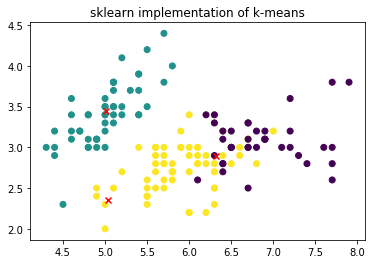

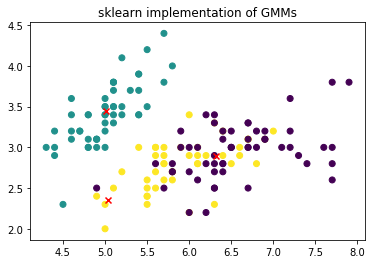

In [57]:
import sklearn.cluster
import sklearn.mixture

# TODO: Create an instance of an sklearn.cluster KMeans object with k clusters
# TODO: Fit our data to the model with .fit(data)
# TODO: Predict data clusters with .predict(data)
k_m = sklearn.cluster.KMeans(n_clusters = k)
k_m.fit(data) 
label = k_m.predict(data) 
# TODO: Plot two feature dimensions against eachother, label with the predicted cluster labels.
# TODO: Plot the cluster centroids on top. Hint: use a different shaped marker with 'marker="x"'.
# TODO: Label axes correctly.
plt.scatter(data[:,0], data[:,1], c = label)
plt.scatter(k_centroid[:,0], k_centroid[:,1], marker='x', c='r')
plt.title('sklearn implementation of k-means')
plt.show() 


# TODO: create an instance of an sklearn.mixture GaussianMixture object with g clusters
# TODO: fit our data to the model with .fit(data)
# TODO: predict data clusters with .predict(data)
gmm = sklearn.mixture.GaussianMixture(n_components = g)
gmm.fit(data) 
label = gmm.predict(data) 
# TODO: Plot two feature dimensions against eachother, label with the predicted cluster labels.
# TODO: Plot the cluster centroids on top. Hint: use a different shaped marker with 'marker="x"'.
# TODO: Label axes correctly.
plt.scatter(data[:,0], data[:,1], c = label) 
plt.scatter(k_centroid[:,0], k_centroid[:,1], marker='x', c='r')
plt.title('sklearn implementation of GMMs')
plt.show() 